In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate
from lmfit.models import PseudoVoigtModel

from ramandecompy import dataprep
from ramandecompy import spectrafit
from ramandecompy import datavis

In [25]:
hdf5_filename = 'spectrafit_dev3.hdf5'
key = '300C/65s'

In [26]:
# dataprep.new_hdf5('spectrafit_dev3')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_25s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_35s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_45s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_55s.csv')
# dataprep.add_experiment(hdf5_filename, '../ramandecompy/tests/test_files/FA_3.6wt%_300C_65s.csv')

In [27]:
# hdf5 = h5py.File(hdf5_filename, 'r+')
# del hdf5['300C/35s']
# hdf5.close()

**** spectrafit_dev3.hdf5 ****
300C
|    25s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber
|    35s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|    |    Peak_10*
|    |    Peak_11*
|    |    Peak_12
|    |    Peak_13
|    |    Peak_14
|    |    Peak_15
|    |    Peak_16
|    |    Peak_17
|    |    Peak_18
|    |    counts
|    |    residuals
|    |    wavenumber
|    45s
|    |    Peak_01
|    |    Peak_02
|    |    Peak_03
|    |    Peak_04
|    |    Peak_05
|    |    Peak_06
|    |    Peak_07
|    |    Peak_08
|    |    Peak_09*
|   

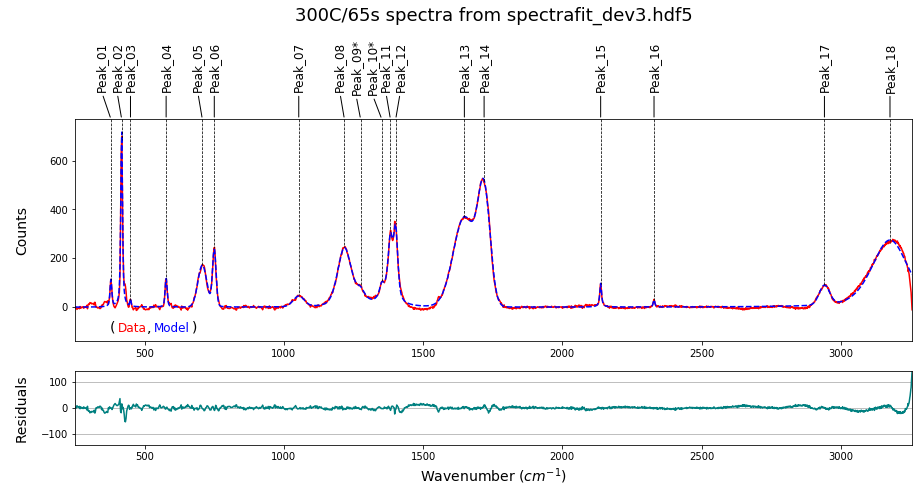

In [28]:
dataprep.view_hdf5(hdf5_filename)
fig, ax1, ax2 = datavis.plot_fit(hdf5_filename, key)
# datavis.plot_components(ax1, hdf5_filename, key, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

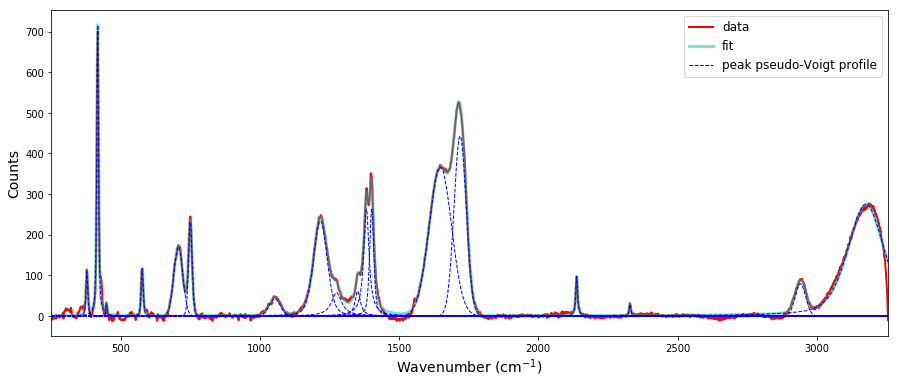

In [24]:
add_list = [1270, 1350]#, 1385]#, 1640]
# add_list = None
drop_list = ['Peak_01']#, 'Peak_02']
# drop_list = None

dataprep.adjust_peaks(hdf5_filename, key, add_list, drop_list, plot_fits=True)

Test to see if applying an existing fit to the next spectra -----------v

In [ ]:
existing_key = '300C/25s'
new_key = '300C/35s'

add_list = None
drop_list = None
hdf5_file = 'spectrafit_dev3.hdf5'

hdf5 = h5py.File(hdf5_file, 'r+')
# extract raw x-y data
x_data = np.asarray(hdf5['{}/{}'.format(new_key, 'wavenumber')])
y_data = np.asarray(hdf5['{}/{}'.format(new_key, 'counts')])
# extract peak center and height locations from hdf5
peaks = []
for _, peak in enumerate(list(hdf5[existing_key])[:-3]):
    peaks.append(list(hdf5['{}/{}'.format(existing_key, peak)]))
# drop desired tuples from peaks
if drop_list is not None:
    drop_index = []
    for _, name in enumerate(drop_list):
        drop_index.append(int(name.split('_')[-1])-1)
    for i, index in enumerate(drop_index):
        peaks.pop(index-i)
else:
    pass
if add_list is not None:
    # interpolate data
    comp_int = interpolate.interp1d(x_data, y_data, kind='cubic')
    # iterate through add_list
    peaks_add = []
    for _, guess in enumerate(add_list):
        height = comp_int(int(guess))
        peaks_add.append((int(guess), int(height)))
else:
    peaks_add = []
# build new model
fit_result, residuals = spectrafit.build_custom_model(x_data, y_data, peaks, peaks_add, plot_fits=True)
# delete old fit data
del hdf5[new_key]
# write data to .hdf5
hdf5['{}/wavenumber'.format(new_key)] = x_data
hdf5['{}/counts'.format(new_key)] = y_data
hdf5['{}/residuals'.format(new_key)] = residuals
for i, _ in enumerate(fit_result):
    if len(fit_result[i]) == 7:
        if i < 9:
            hdf5['{}/Peak_0{}'.format(new_key, i+1)] = fit_result[i][:6]
        else:
            hdf5['{}/Peak_{}'.format(new_key, i+1)] = fit_result[i][:6]
    elif len(fit_result[i]) == 8:
        if i < 9:
            hdf5['{}/Peak_0{}*'.format(new_key, i+1)] = fit_result[i][:6]
        else:
            hdf5['{}/Peak_{}*'.format(new_key, i+1)] = fit_result[i][:6]
    else:
        print('fit_result for Peak_{} contains an inappropriate number of values'.format(i))
hdf5.close()
